# Water Mass Transformation diagnostics using ACCESS-OM2 neutral diagnostics

This is a example code for working with the Water Mass Transformation output from the neutral `_on_nrho` diagnostics for a tracer

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import os

import IPython.display

import cosima_cookbook as cc

At the moment the diagnostics have to be output from a particular run or runs of ACCESS-OM2. Specify the output directory on Gadi

In [2]:
output_dir = r'/scratch/e14/cb2411/access-om2/archive/1deg_jra55_ryf/'

In [3]:
outputs = sorted([_ for _ in os.listdir(output_dir) if _.startswith('output')])
dir_list = sorted([os.path.join(output_dir, _) for _ in outputs])

To make the database, specify a location you have write access to (assign `db_path`)

In [4]:
db_path = r'/g/data/e14/cb2411/data'
session = cc.database.create_session(os.path.join(db_path, 'wmt_diags.db'))

In [5]:
cc.database.build_index(dir_list,session,update=True)

0it [00:00, ?it/s]
0it [00:00, ?it/s]

Indexing experiment: output050
Indexing experiment: output051



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Indexing experiment: output052
Indexing experiment: output053
Indexing experiment: output054
Indexing experiment: output055


0it [00:00, ?it/s]


0

In [6]:
# make list of experiments - at the moment this is the number of runs in a single experiment
# chat to COSIMA about making the cc.database.create_session(...) work with a dictionary
# to be able to specficy the file structure of the experiments 
# (running multiple "experiments" - say a control and perturbation will have the same names?)
exp = list(cc.querying.get_experiments(session)['experiment'])

Specificy the neutral coordinate (either temperature or salt). This is use to construct the variable names used in the `.getvar` method

In [7]:
neutral_coordinate = 'salt'

In [37]:
diags = {'diffusion': ['salt_vdiffuse_diff_cbt_on_nrho', 'salt_nonlocal_KPP_on_nrho', 
                      'neutral_diffusion_on_nrho_salt','salt_vdiffuse_k33_on_nrho', 
                      'mixdownslope_salt_on_nrho','salt_sigma_diff_on_nrho'], 
        'skew-diffusion': ['neutral_gm_on_nrho_salt', 'salt_submeso_on_nrho'],
        'tracer_sbc': ['salt_vdiffuse_sbc_on_nrho', 'salt_eta_smooth_on_nrho', 'salt_rivermix_on_nrho'],
        'volume_sbc': ['mass_pmepr_on_nrho'],
        }

We are interested in the processes which transport a general tracer $\mathbb{C}$ across surface of constant tracer values, $C^{*}$. In general, $C^{*}$ do not need to be iso-surfaces of the the concentration of $\mathbb{C}$.

We wish to calculate the terms of the  time-averaged internal budget for a tracer $\mathbb{C}(C^{*}, t)$,  
$$\partial \mathbb{C}/\partial t = -F - D,$$
where $F$ and $D$ are the forcing and diffusion

In [46]:
# warnings disabled for development
import warnings
warnings.simplefilter("ignore")

P = cc.querying.getvar('output051', 'mass_pmepr_on_nrho', session)
area = cc.querying.getvar('output051', 'area_t', session).rename({'xt_ocean':'grid_xt_ocean', 
                                                                  'yt_ocean':'grid_yt_ocean'})
isohalines = cc.querying.getvar('output051', 'neutral', session)
sfc_tracer = 0
for _ in diags['tracer_sbc']:
    sfc_tracer = sfc_tracer + cc.querying.getvar('output051', _, session)*area
Forcing_av = P.sum(dim=['grid_yt_ocean', 'grid_xt_ocean']).cumsum(dim='neutral').mean(dim='time')*isohalines/1000 -\
            sfc_tracer.sum(dim=['grid_yt_ocean', 'grid_xt_ocean']).cumsum(dim='neutral').mean(dim='time')
diff_on_nrho = 0
for _ in diags['diffusion']:
    diff_on_nrho = diff_on_nrho + cc.querying.getvar('output051', _, session)*area
Subgrid_diff_av = diff_on_nrho.sum(dim=['grid_yt_ocean', 'grid_xt_ocean']).cumsum(dim='neutral').mean(dim='time')
skew_on_nrho = 0
for _ in diags['skew-diffusion']:
    skew_on_nrho = skew_on_nrho + cc.querying.getvar('output051', _, session)*area
Subgrid_skew_av = skew_on_nrho.sum(dim=['grid_yt_ocean', 'grid_xt_ocean']).cumsum(dim='neutral').mean(dim='time')



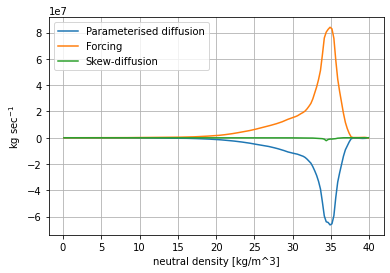

In [51]:
# plotting
(-Subgrid_diff_av).plot()
Forcing_av.plot()
(-Subgrid_skew_av).plot()
plt.grid()
plt.ylabel("kg sec$^{-1}$")
plt.legend(['Parameterised diffusion', 'Forcing', 'Skew-diffusion'])
plt.show()